In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Submission for Common Test I. Multi-Class Classification**

**Task:** Build a model for classifying the images into lenses using PyTorch or Keras. Pick the most appropriate approach and discuss your strategy.

**Dataset:** dataset.zip - Google Drive

**Dataset Description:** The Dataset consists of three classes, strong lensing images with no substructure, subhalo substructure, and vortex substructure. The images have been normalized using min-max normalization, but you are free to use any normalization or data augmentation methods to improve your results.

**Evaluation Metrics:** ROC curve (Receiver Operating Characteristic curve) and AUC score (Area Under the ROC Curve) 

### Solution:

*Here I have implemented an ensemble for only one epoch due to computational limits at my end. But the similar code can be implemented to train various models for more epochs to attain a better classification and also choose the better model by comparing them.*

# Statergy

The motivation behind using the ensemble model was the fact to reduce generalisation error and rather use the fact that this type of model seeks the wisdom of a crowd to make a prediction. Though the best answer would be obtained when these different models are trained and compared because the best model depends on the data firstly both quality and size but also as here computational resources is a concern training multiple models is not possible.

In [1]:
!pip install timm

In [2]:
import os
import glob
from pandas.core.common import flatten
import timm

In [3]:
from collections import Counter
from collections import defaultdict

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms, utils, datasets
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from sklearn.metrics import classification_report, confusion_matrix

In [5]:
# !unzip "/content/drive/MyDrive/dataset.zip" -d "/content/drive/MyDrive/dataset"

In [6]:
np.random.seed(0)
torch.manual_seed(0)

In [7]:
%matplotlib inline
sns.set_style('darkgrid')

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("We're using =>", device)
root_dir = "/kaggle/input/deeplense"
print("The data lies here =>", root_dir)

We're using => cuda
The data lies here => /kaggle/input/deeplense


In [9]:
train_base_path = "/kaggle/input/deeplense/dataset/train"
val_base_path = "/kaggle/input/deeplense/dataset/val"
class_folders = ["no", "sphere", "vort"]

In [10]:
train_image_paths = []
val_image_paths = []
classes = []

for train_data_path in glob.glob(train_base_path + "/*"):
    classes.append(train_data_path.split("/")[-1])
    train_image_paths.append(glob.glob(train_data_path + "/*"))

for val_data_path in glob.glob(train_base_path + "/*"):
    val_image_paths.append(glob.glob(val_data_path + "/*"))

train_image_paths = list(flatten(train_image_paths))
val_image_paths = list(flatten(val_image_paths))

print(f"Train Size: {len(train_image_paths)}\nVal Size: {len(val_image_paths)}")

Train Size: 30000
Val Size: 30000


In [11]:
print(classes)

['no', 'vort', 'sphere']


In [12]:
idx_to_class = {i: j for i, j in enumerate(classes)}
class_to_idx = {value: key for key, value in idx_to_class.items()}

print(f"Index to class dictionary: {idx_to_class}")
print(f"Class to index dictionary: {class_to_idx}")

Index to class dictionary: {0: 'no', 1: 'vort', 2: 'sphere'}
Class to index dictionary: {'no': 0, 'vort': 1, 'sphere': 2}


In [13]:
class NPYDataset(Dataset):
    def __init__(self, image_paths, transform=False):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_filepath = self.image_paths[idx]
        image = np.load(image_filepath)

        if(self.transform is not False):
            image = self.transform(image=image)["image"]

        label = image_filepath.split("/")[-2]
        label = class_to_idx[label]

        return image, label

train_dataset = NPYDataset(image_paths=train_image_paths, transform=False)
val_dataset = NPYDataset(image_paths=val_image_paths, transform=False)

# Creating Dataloaders

In [14]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [15]:
class TransferLearningModelOld(nn.Module):

    def __init__(self, n_classes):
        super(TransferLearningModelOld, self).__init__()
        self.transfer_learning_model = timm.create_model('densenet161', pretrained=True, in_chans=1)

        for param in self.transfer_learning_model.parameters():
            param.requires_grad = True

        self.classifier = nn.Sequential(
            nn.Linear(2208 * 4 * 4, 1024),
            nn.ReLU(),
            nn.BatchNorm1d(1024),
            nn.Dropout(p=0.25),
            nn.Linear(1024, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(p=0.25),
            nn.Linear(64, n_classes)
        )

    def forward(self, x):
        x = self.transfer_learning_model.forward_features(x)
        x = x.view(-1, 2208 * 4 * 4)
        x = self.classifier(x)

        return x

class TransferLearningModelNew(nn.Module):

    def __init__(self, n_classes):
        super(TransferLearningModelNew, self).__init__()
        self.transfer_learning_model = timm.create_model('densenet161', pretrained=True, in_chans=1)

        for param in self.transfer_learning_model.parameters():
            param.requires_grad = True

        self.classifier = nn.Sequential(
            nn.Linear(2208 * 4 * 4, 1024),
            nn.ReLU(),
            nn.BatchNorm1d(1024),
            nn.Dropout(p=0.33),
            nn.Linear(1024, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(p=0.33),
            nn.Linear(64, n_classes)
        )

    def forward(self, x):
        x = self.transfer_learning_model.forward_features(x)
        x = x.view(-1, 2208 * 4 * 4)
        x = self.classifier(x)

        return x

class DenseNet201(nn.Module):

    def __init__(self, n_classes):
        super(DenseNet201, self).__init__()
        self.transfer_learning_model = timm.create_model("densenet201", pretrained=True, in_chans=1)

        for param in self.transfer_learning_model.parameters():
            param.requires_grad = True

        self.classifier = nn.Sequential(
            nn.Linear(1920 * 4 * 4, 1024),
            nn.ReLU(),
            nn.BatchNorm1d(1024),
            nn.Dropout(p=0.33),
            nn.Linear(1024, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(p=0.33),
            nn.Linear(64, n_classes)
        )

    def forward(self, x):
        x = self.transfer_learning_model.forward_features(x)
#         print(x.shape)
        x = x.view(-1, 1920 * 4 * 4)
        x = self.classifier(x)

        return x

class MobileVitV2_150(nn.Module):

    def __init__(self, n_classes):

        super(MobileVitV2_150, self).__init__()

        self.vit_model = timm.create_model("mobilevitv2_150_384_in22ft1k", pretrained=True, in_chans=1)

        for param in self.vit_model.parameters():
            param.requires_grad = True

        self.classifier = nn.Sequential(
            nn.Linear(768 * 6 * 6, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(p=0.3),
            nn.Linear(512, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(p=0.3),
            nn.Linear(64, n_classes)
        )

    def forward(self, x):
        x = self.vit_model.forward_features(x)
#         print(x.shape)
        x = x.reshape(-1, 768 * 6 * 6)
        x = self.classifier(x)

        return x

# (test performance of an ensemble)
class DenseNetEnsemble(nn.Module):

    def __init__(self, n_classes, modela, modelb):

        super(DenseNetEnsemble, self).__init__()

        self.modela = modela
        self.modelb = modelb

    def forward(self, x):
        outa = self.modela(x)
        outb = self.modelb(x)
        out = outa + outb
        x = out

        return x

In [16]:
modela = TransferLearningModelNew(len(classes))
modela = modela.to(device)

modelb = DenseNet201(len(classes))
modelb = modelb.to(device)

model = DenseNetEnsemble(len(classes), modela, modelb)
model = model.to(device)

model.safetensors:   0%|          | 0.00/116M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/81.1M [00:00<?, ?B/s]

In [17]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [18]:
def train_one_epoch(model, optimizer, data_loader, device):

    model.train()

    total = 0
    correct = 0
    train_accuracy = []
    train_loss = []

    for i, data in enumerate(tqdm(data_loader)):
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)

        y_pred = model(images.float())
        loss = criterion(y_pred, labels)

        _, predicted = torch.max(y_pred.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        accuracy = 100 * correct / total

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if(i % 10 == 0):
            print(f"Loss: {loss}, Accuracy: {accuracy}")

        train_accuracy.append(torch.tensor(accuracy))
        train_loss.append(torch.tensor(loss))

    return train_accuracy, train_loss

In [19]:
def test_model(model, data_loader, device):

    model.eval()

    total = 0
    correct = 0
    val_accuracy = []
    val_loss = []

    with torch.no_grad():
        for i, data in enumerate(tqdm(data_loader)):
            images, labels = data

            images = images.to(device)
            labels = labels.to(device)

            y_pred = model(images.float())
            loss = criterion(y_pred, labels)

            _, predicted = torch.max(y_pred.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            accuracy = 100 * correct / total

            val_accuracy.append(torch.tensor(accuracy))
            val_loss.append(torch.tensor(loss))

    return val_accuracy, val_loss

In [20]:
def convert_tensor_list_to_single_mean_value(tensor_list):

    tensor_list = [tensor.detach().cpu().numpy() for tensor in tensor_list]

    return np.mean(tensor_list)

# Training the Model

In [22]:
history = defaultdict(list)
best_accuracy = 0
model_name = "ensemble"

for epoch in range(1):
    print(f"Epoch {epoch + 1} / {1}")
    print('=' * 10)

    train_accuracy, train_loss = train_one_epoch(model=model, optimizer=optimizer, data_loader=train_loader, device=device)
    train_accuracy = convert_tensor_list_to_single_mean_value(tensor_list=train_accuracy)
    train_loss = convert_tensor_list_to_single_mean_value(tensor_list=train_loss)
    print(f'Train loss: {train_loss}\nTrain accuracy: {train_accuracy}\n')

    val_accuracy, val_loss = test_model(model=model, data_loader=val_loader, device=device)
    val_accuracy = convert_tensor_list_to_single_mean_value(tensor_list=val_accuracy)
    val_loss = convert_tensor_list_to_single_mean_value(tensor_list=val_loss)
    print(f'Val loss: {val_loss}\nVal accuracy: {val_accuracy}\n')

    history['train_acc'].append(train_accuracy)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_accuracy)
    history['val_loss'].append(val_loss)

    if(val_accuracy > best_accuracy):
        torch.save(model.state_dict(),
                   f'{model_name}_epochs_{1}_batchsize_{32}_lr_{1e-4}.bin')
        best_accuracy = val_accuracy

Epoch 1 / 1


  0%|          | 0/938 [00:00<?, ?it/s]

Loss: 1.3516302108764648, Accuracy: 43.75


/tmp/ipykernel_34/2491658244.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_loss.append(torch.tensor(loss))


Loss: 1.3409669399261475, Accuracy: 39.77272727272727
Loss: 1.4766849279403687, Accuracy: 38.392857142857146
Loss: 1.164479374885559, Accuracy: 38.00403225806452
Loss: 1.360531210899353, Accuracy: 38.64329268292683
Loss: 1.395958662033081, Accuracy: 38.72549019607843
Loss: 1.2904011011123657, Accuracy: 38.98565573770492
Loss: 1.039555311203003, Accuracy: 38.99647887323944
Loss: 1.5957282781600952, Accuracy: 38.27160493827161
Loss: 1.0764493942260742, Accuracy: 38.5989010989011
Loss: 1.1914849281311035, Accuracy: 38.211633663366335
Loss: 1.0801615715026855, Accuracy: 38.119369369369366
Loss: 1.154944896697998, Accuracy: 38.37809917355372
Loss: 1.2356473207473755, Accuracy: 38.64503816793893
Loss: 1.2113771438598633, Accuracy: 38.519503546099294
Loss: 1.1395596265792847, Accuracy: 38.80380794701987
Loss: 1.1028187274932861, Accuracy: 38.76164596273292
Loss: 1.1326189041137695, Accuracy: 38.998538011695906
Loss: 1.4420063495635986, Accuracy: 39.226519337016576
Loss: 1.1099681854248047, Ac

  0%|          | 0/938 [00:00<?, ?it/s]

/tmp/ipykernel_34/4206507292.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_loss.append(torch.tensor(loss))


Val loss: 0.42116478085517883
Val accuracy: 90.39885711669922



In [23]:
from matplotlib.ticker import MaxNLocator
import gc

In [25]:
history

defaultdict(list,
            {'train_acc': [48.13741],
             'train_loss': [0.8515054],
             'val_acc': [90.39886],
             'val_loss': [0.42116478]})

In [ ]:
del model, train_loader, history
gc.collect()

In [29]:
import torch.nn.functional as nnf

# Model Predictions

In [31]:
def get_model_predictions(model, data_loader, device):

    model.eval()

    total = 0
    correct = 0
    val_accuracy = []
    val_loss = []
    y_test_all = []
    y_pred_all = []
    y_pred_prob_all = []

    with torch.no_grad():
        for i, data in enumerate(tqdm(data_loader)):
            images, labels = data

            images = images.to(device)
            labels = labels.to(device)
            y_test_all.append(labels)

            y_pred = model(images.float())
#             print("y_pred:", y_pred, y_pred.shape)
            prob = nnf.softmax(y_pred, dim=1)
#             print("prob:", prob, prob.shape)
            loss = criterion(y_pred, labels)

            _, predicted = torch.max(y_pred.data, 1)
#             print("predicted", predicted, predicted.shape)
            y_pred_prob_all.append(prob)
            y_pred_all.append(predicted)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            accuracy = 100 * correct / total

            val_accuracy.append(torch.tensor(accuracy))
            val_loss.append(torch.tensor(loss))

    return val_accuracy, val_loss, y_test_all, y_pred_all, y_pred_prob_all
test_accuracy, test_loss, y_test, y_pred, y_pred_prob = get_model_predictions(model=model, data_loader=val_loader, device=device)

  0%|          | 0/938 [00:00<?, ?it/s]

/tmp/ipykernel_34/4062267037.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_loss.append(torch.tensor(loss))


In [32]:
def get_flat_arrays(arrays):
    arrays = [tensor.detach().cpu().numpy() for tensor in arrays]
    arrays = np.concatenate(arrays)
    arrays = arrays.ravel()

    return arrays

y_test = get_flat_arrays(arrays=y_test)
y_pred = get_flat_arrays(arrays=y_pred)

In [34]:
import sklearn
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score, confusion_matrix, roc_curve, auc, roc_auc_score

# Classification Report and Confusion Matrix

========== For Ensemble_DenseNet161_DenseNet201_Epochs_1 ==========

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.96      0.86     10000
           1       0.92      0.77      0.84     10000
           2       0.85      0.79      0.82     10000

    accuracy                           0.84     30000
   macro avg       0.85      0.84      0.84     30000
weighted avg       0.85      0.84      0.84     30000



F1 Score: 0.8388286929313118
Precision: 0.848309338457389
Recall: 0.8399666666666666




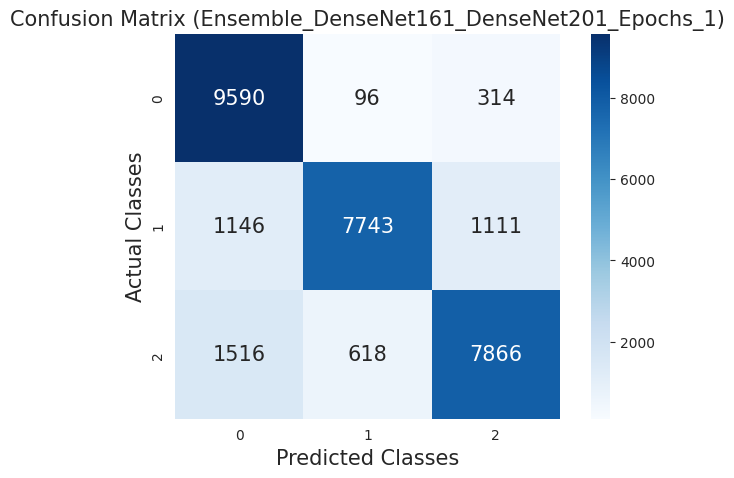

In [35]:
def get_model_classification_report_and_confusion_matrix(model_name, y_test, y_pred):

    print("=" * 10, f"For {model_name}", "=" * 10)
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    print("\n")
    print(f"F1 Score: {f1_score(y_test, y_pred, average = 'weighted')}")
    print(f"Precision: {precision_score(y_test, y_pred, average = 'weighted')}")
    print(f"Recall: {recall_score(y_test, y_pred, average = 'weighted')}")
    print("\n")
    plt.figure(figsize = (8, 5))
    ax = plt.axes()
    ax = sns.heatmap(confusion_matrix(y_test, y_pred), annot = True, square = True, fmt = "d", cmap = "Blues", cbar = True, annot_kws={'size': 15})
    ax.xaxis.set_tick_params(labelsize = 10)
    ax.yaxis.set_tick_params(labelsize = 10)
    plt.title(f"Confusion Matrix ({model_name})", fontsize = 15)
    plt.ylabel("Actual Classes", fontsize = 15)
    plt.xlabel("Predicted Classes", fontsize = 15)
    plt.show()
    print("\n")

get_model_classification_report_and_confusion_matrix("Ensemble_DenseNet161_DenseNet201_Epochs_1", y_test, y_pred)

In [36]:
def one_hot_encode_array(array, num_classes):

    return np.squeeze(np.eye(num_classes)[array.reshape(-1)])

y_test = one_hot_encode_array(array=y_test, num_classes=len(classes))
y_pred = one_hot_encode_array(array=y_pred, num_classes=len(classes))

def get_flattened_array(array):

    flattened_array = []

    for row in array:
        for col in row:
            flattened_array.append(col)

    return flattened_array

def get_required_array_format(array):

    array = get_flattened_array(array)
    array = [tensor.detach().cpu().numpy() for tensor in array]
    array = np.array(array)

    return array

In [38]:
y_pred_prob = get_required_array_format(y_pred_prob)

# ROC-AUC Curves

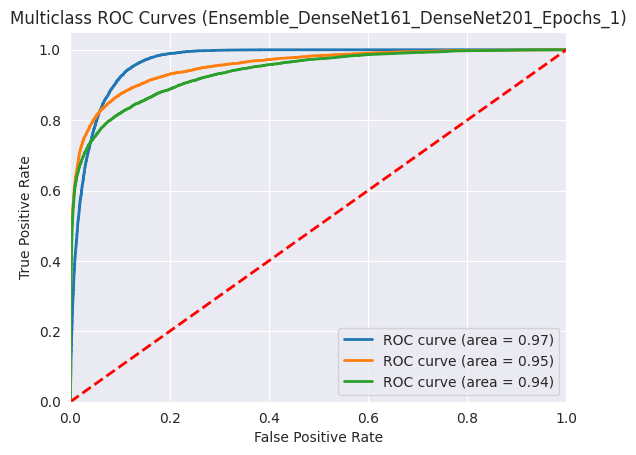

In [39]:
def plot_auc_score_and_multiclass_roc_curves(y_test, y_pred_prob, model_name):

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    n_classes = len(classes)

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_prob[:, i], )
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure()
    lw = 2
    for i in range(len(classes)):
        plt.plot(fpr[i], tpr[i], lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], color='red', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Multiclass ROC Curves ({model_name})')
    plt.legend(loc="lower right")
    plt.show()

plot_auc_score_and_multiclass_roc_curves(y_test, y_pred_prob, "Ensemble_DenseNet161_DenseNet201_Epochs_1")

# AUC Score

In [40]:
def get_auc_score(y_test, y_pred_prob, model_name):

    print(10 * "=", f"For {model_name}", 10 * "=")

    auc_ovo = roc_auc_score(y_test, y_pred_prob, multi_class="ovo")
    auc_ovr = roc_auc_score(y_test, y_pred_prob, multi_class="ovr")

    print('AUC (OVO): %.2f' % auc_ovo)
    print('AUC (OVR): %.2f' % auc_ovr)

get_auc_score(y_test, y_pred_prob, "Ensemble_DenseNet161_DenseNet201_Epochs_1")

========== For Ensemble_DenseNet161_DenseNet201_Epochs_1 ==========
AUC (OVO): 0.95
AUC (OVR): 0.95
